In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from CDAE import AutoEncoder
from tqdm import trange
from utils import *

/Users/larry/Py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('../data/itri/rating_itri.csv')
df['freq'] = df.groupby('uid')['uid'].transform('count')  # count frequncy by column's values
df = df[df['freq'] > 5]  # remove row which corresponding frequence < 5

userList = df['uid'].unique()
itemList = df['iid'].unique()

total_usr = len(df['uid'].unique())
total_item = len(df['iid'].unique())

sparsity = len(df)/(total_usr*total_item)
print("sparsity of ratings is %.2f%%" %(sparsity*100))
print ("num. of users: %d, num. of items: %d" % (total_usr, total_item))

sparsity of ratings is 33.01%
num. of users: 332, num. of items: 1002


In [3]:
import math
def get_map(list_):
    map_ = {}
    for idx, ident in enumerate(list_):
        map_[ident] = idx
        
    return map_

def get_matrix(data):
    matrix = np.zeros((total_usr, total_item), dtype=np.float32)
    for line in data:
        uid = user_map[line[0]]
        iid = item_map[line[1]]
        matrix[uid, iid] = 1
    
    return matrix

def train_test_split(df, time_interval, split_rate=0.5):
    start_time = min(df['timestamp'])
    end_time = max(df['timestamp'])
    time_elapse = (end_time-start_time) // time_interval
    split_time = start_time + math.floor(time_elapse * (1-split_rate)) * time_interval
    
    while split_time < end_time:
        df_train = df[df['timestamp'] < split_time]
        df_train = df_train[df_train['timestamp'] >= start_time]
        
        df_test_1 = df[df['timestamp'] >= split_time - 3*time_interval]
        df_test_1 = df_test_1[df_test_1['timestamp'] < split_time]
        
        df_test_2 = df[df['timestamp'] >= split_time]
        df_test_2 = df_test_2[df_test_2['timestamp'] < split_time + time_interval]
        
        # start_time += time_interval
        # split_time = start_time + math.floor(time_elapse * (1-split_rate)) * time_interval
        split_time += time_interval
        
        yield df_train, df_test_1, df_test_2

In [4]:
user_map = get_map(userList)
item_map = get_map(itemList)
    
user_time_interval = 7 * 24 * 3600

# New user/item rate

In [10]:
generator = train_test_split(df, user_time_interval)

new_user_rate = []
new_item_rate = []
while True:
    try:
        df_train, df_test_1, df_test_2 = next(generator)
        
        train_user = []
        train_item = []
        test_user = []
        test_item = []
        
        for i in df_train['uid']:
            if i not in train_user:
                train_user.append(i)
                
        for i in df_train['iid']:
            if i not in train_item:
                train_item.append(i)
        
        for i in df_test_2['uid']:
            if i not in test_user:
                test_user.append(i)
        
        for i in df_test_2['iid']:
            if i not in test_item:
                test_item.append(i)
        
        count = 0
        for i in test_user:
            if i not in train_user:
                count += 1
        new_user_rate.append(count/len(test_user))
        
        count = 0
        for i in test_item:
            if i not in train_item:
                count += 1
        new_item_rate.append(count/len(test_item))
    except StopIteration:
        break

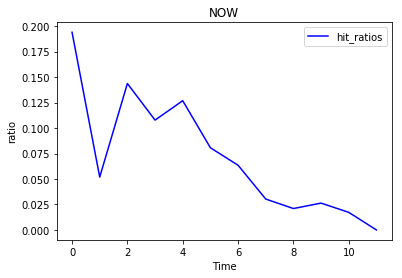

0.07847131106611761


In [11]:
plt.plot(range(len(new_user_rate)), new_user_rate, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title('NOW')
plt.ylabel('ratio')
plt.show()
plt.gcf().clear()
print (sum(new_user_rate[:-1])/len(new_user_rate[:-1]))

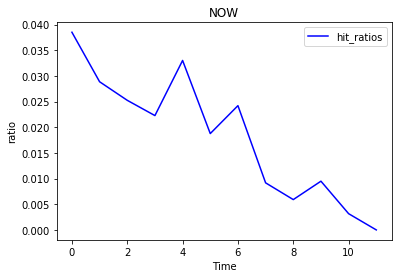

0.019878538025275245


In [12]:
plt.plot(range(len(new_item_rate)), new_item_rate, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title('NOW')
plt.ylabel('ratio')
plt.show()
plt.gcf().clear()
print (sum(new_item_rate[:-1])/len(new_item_rate[:-1]))

# Train

In [ ]:
generator = train_test_split(df, user_time_interval)

tf.reset_default_graph()

autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='log_loss',
                          epochs=200)

test_out_top = []
top_items_list_all = []
top_items_list_75 = []
top_items_list_85 = []
top_means_list = []
top_gt_list_next = []
top_gt_list_now = []

while True:
    try:
        df_train, df_test_1, df_test_2 = next(generator)

        train_data = df_train.as_matrix()
        test_data_1 = df_test_1.as_matrix()
        test_data_2 = df_test_2.as_matrix()

        user_train_matrix = get_matrix(train_data)
        user_test_matrix_1 = get_matrix(test_data_1)
        user_test_matrix_2 = get_matrix(test_data_2)

        train_user = np.nonzero(np.count_nonzero(user_train_matrix, axis=1))[0]
        test_user_1 = np.nonzero(np.count_nonzero(user_test_matrix_1, axis=1))[0]

        # train_rating, train_indices, test_indices = gen_train_test(user_train_matrix)

        autoencoder.train_all(rating=user_train_matrix, train_idents=train_user)

        test_out = autoencoder.predict(user_test_matrix_1, test_user_1)
        
        """ out data process """
        # all data mean
        test_out_stat_all = np.mean(test_out, axis=0)
        
        # upper quartile mean
        test_out_stat_75 = []
        quartile_75 = np.percentile(test_out, 75, axis=0)
        for i in range(test_out.shape[1]):
            test_out_stat_75.append(np.mean([x for x in test_out.T[i] if x > quartile_75[i]]))
        test_out_stat_75 = np.asarray(test_out_stat_75)
        
        test_out_stat_85 = []
        quartile_85 = np.percentile(test_out, 85, axis=0)
        for i in range(test_out.shape[1]):
            test_out_stat_85.append(np.mean([x for x in test_out.T[i] if x > quartile_85[i]]))
        test_out_stat_85 = np.asarray(test_out_stat_85)
        
        """Get top 10"""
        test_out_rank_all = test_out_stat_all.argsort()[::-1][:10]
        test_out_rank_75 = test_out_stat_75.argsort()[::-1][:10]
        test_out_rank_85 = test_out_stat_85.argsort()[::-1][:10]
        ground_truth_next = np.count_nonzero(user_test_matrix_2, axis=0).argsort()[::-1][:10]
        ground_truth_now = np.count_nonzero(user_test_matrix_1, axis=0).argsort()[::-1][:10]
        
        """out data collect"""
        top_out = np.take(test_out, test_out_rank_all, axis=1).T
        test_out_top.append(top_out)
        
        top_items_list_all.append(test_out_rank_all)
        top_items_list_75.append(test_out_rank_75)
        top_items_list_85.append(test_out_rank_85)
        top_gt_list_next.append(ground_truth_next)
        top_gt_list_now.append(ground_truth_now)
        
        means = []
        for i in test_out_rank_all:
            means.append((i, test_out_stat_all[i]))
        top_means_list.append(means)
        
        """out data performance"""
        # hit_ratio_next.append(recall_at_N(test_out_rank, ground_truth_next))
        # hit_ratio_now.append(recall_at_N(test_out_rank, ground_truth_now))
        
    except StopIteration:
        break
        
# test_out_top = np.asarray(test_out_top)
top_items_list_all = np.asarray(top_items_list_all)
top_items_list_75 = np.asarray(top_items_list_75)
top_items_list_85 = np.asarray(top_items_list_85)
top_means_list = np.asarray(top_means_list)
top_gt_list_now = np.asarray(top_gt_list_now)
top_gt_list_next = np.asarray(top_gt_list_next)

In [ ]:
for i in trange(top_means_list.shape[0]):
    for j in range(top_means_list.shape[1]):
        if top_items_list_all[i][j] in top_gt_list_now[i]:
            plt.plot(range(len(test_out_top[i][j])), test_out_top[i][j], color='green', label='pred. scores')
            plt.hlines(top_means_list[i][j][1], -5, len(test_out_top[i][j])+5, linestyles='solid', color='blue')
            plt.legend(loc="upper right")
            plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list_all[i][j], top_means_list[i][j][1]))
            plt.xlabel('Users')
            plt.ylabel('score')
            plt.savefig("plots_netflix_now/scores_%d_%d.jpg" % (i, j))
        else:
            plt.plot(range(len(test_out_top[i][j])), test_out_top[i][j], color='red', label='pred. scores')
            plt.hlines(top_means_list[i][j][1], -5, len(test_out_top[i][j])+5, linestyles='solid', color='blue')
            plt.legend(loc="upper right")
            plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list_all[i][j], top_means_list[i][j][1]))
            plt.xlabel('Users')
            plt.ylabel('score')
            plt.savefig("plots_netflix_now/scores_%d_%d.jpg" % (i, j))
        # plt.show()
        plt.gcf().clear()

# Itri

In [ ]:
hit_ratio_top_10 = []
hit_ratio_top_5 = []

for i, j in zip(top_items_list_85, top_gt_list_next):
    hit_ratio_top_10.append(recall_at_N(i, j))
    
for i, j in zip(top_items_list_85, top_gt_list_next):
    hit_ratio_top_5.append(recall_at_N(i[:5], j[:5]))

## all data mean

In [ ]:
plt.plot(range(len(hit_ratio_top_10)), hit_ratio_top_10, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.title('NOW')
plt.ylabel('ratio')
plt.show()
plt.gcf().clear()
print (sum(hit_ratio_top_10)/len(hit_ratio_top_10))
print (sum(hit_ratio_top_5)/len(hit_ratio_top_5))

In [ ]:
plt.plot(range(len(hit_ratio_top_10)), hit_ratio_top_10, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.ylabel('ratio')
plt.title('NEXT')
plt.show()
plt.gcf().clear()
print (sum(hit_ratio_top_10)/len(hit_ratio_top_10))
print (sum(hit_ratio_top_5)/len(hit_ratio_top_5))

## upper quartile mean

In [ ]:
plt.plot(range(len(hit_ratio_top_10)), hit_ratio_top_10, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.ylabel('ratio')
plt.title('NOW')
plt.show()
plt.gcf().clear()
print (sum(hit_ratio_top_10)/len(hit_ratio_top_10))
print (sum(hit_ratio_top_5)/len(hit_ratio_top_5))

In [ ]:
plt.plot(range(len(hit_ratio_top_10)), hit_ratio_top_10, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.ylabel('ratio')
plt.title('NEXT')
plt.show()
plt.gcf().clear()
print (sum(hit_ratio_top_10)/len(hit_ratio_top_10))
print (sum(hit_ratio_top_5)/len(hit_ratio_top_5))

## Upper 85 mean

In [ ]:
plt.plot(range(len(hit_ratio_top_10)), hit_ratio_top_10, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.ylabel('ratio')
plt.title('NOW')
plt.show()
plt.gcf().clear()
print (sum(hit_ratio_top_10)/len(hit_ratio_top_10))
print (sum(hit_ratio_top_5)/len(hit_ratio_top_5))

In [ ]:
plt.plot(range(len(hit_ratio_top_10)), hit_ratio_top_10, color='blue', label='hit_ratios')
plt.legend(loc="upper right")
# plt.title("Time: %d, Item: %d, mean: %f" % (i, top_items_list[i][j], top_means_list[i][j][1]))
plt.xlabel('Time')
plt.ylabel('ratio')
plt.title('NEXT')
plt.show()
plt.gcf().clear()
print (sum(hit_ratio_top_10)/len(hit_ratio_top_10))
print (sum(hit_ratio_top_5)/len(hit_ratio_top_5))

# Netflix

## all data mean

In [ ]:
print ("TOP 10 NOW: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NOW: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

In [ ]:
print ("TOP 10 NEXT: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NEXT: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

## upper quartile mean

In [ ]:
print ("TOP 10 NOW: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NOW: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

In [ ]:
print ("TOP 10 NEXT: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NEXT: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

## Upper 85 mean

In [ ]:
print ("TOP 10 NOW: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NOW: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

In [ ]:
print ("TOP 10 NEXT: %f" % (sum(hit_ratio_top_10)/len(hit_ratio_top_10)))
print ("TOP 5 NEXT: %f" % (sum(hit_ratio_top_5)/len(hit_ratio_top_5)))

# TOP N Ratio

In [ ]:
generator = train_test_split(df, user_time_interval)

gt_list = []
gtt = []
while True:
    try:
        df_train, df_test_1, df_test_2 = next(generator)

        test_data_2 = df_test_2.as_matrix()

        user_test_matrix_2 = get_matrix(test_data_2)
        
        ground_truth_idx = np.count_nonzero(user_test_matrix_2, axis=0).argsort()[::-1][:30]
        ground_truth = np.take(np.count_nonzero(user_test_matrix_2, axis=0), ground_truth_idx)
        
        ground_truth_rate = np.divide(sum(ground_truth), sum(np.count_nonzero(user_test_matrix_2, axis=0)))
        gt_list.append(ground_truth_rate)
        gtt.append(user_test_matrix_2.shape[0])
    except StopIteration:
        break


## ITRI TOP N ratio

In [ ]:
plt.plot(range(len(gt_list)), gt_list, color='blue', label='in_ratios')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title('top 30')
plt.ylabel('ratio')
plt.show()
plt.gcf().clear()

In [ ]:
plt.plot(range(len(gt_list)), gt_list, color='blue', label='in_ratios')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title('top 10')
plt.ylabel('ratio')
plt.show()
plt.gcf().clear()

## Netflix Top N ratio

In [ ]:
plt.plot(range(len(gt_list)), gt_list, color='blue', label='in_ratios')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title('top 30')
plt.ylabel('ratio')
plt.show()
plt.gcf().clear()

In [ ]:
plt.plot(range(len(gt_list)), gt_list, color='blue', label='in_ratios')
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title('top 10')
plt.ylabel('ratio')
plt.show()
plt.gcf().clear()

# Debug

In [ ]:
# from sklearn.model_selection import train_test_split

df_train, df_test, _, _ = next(generator)

train_data = df_train.as_matrix()
test_data = df_test.as_matrix()

user_train_rating = np.zeros((total_usr, total_item), dtype=np.float32)
for line in train_data:
    uid = user_map[line[0]]
    iid = item_map[line[1]]
    user_train_rating[uid, iid] = 1
    
item_train_rating = user_train_rating.T

In [ ]:
a = np.percentile(test_out, 75, axis=0)
k = []
for i in range(test_out.shape[1]):
    k.append(np.mean([x for x in test_out.T[i] if x > a[i]]))

In [ ]:
print (len(sorted(k, reverse=True)))